# RO47002 Machine Learning for Robotics
* (c) TU Delft, 2024
* Period: 2024-2025, Q1
* Course homepage: https://brightspace.tudelft.nl/d2l/home/682421

Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. Moreover, if you see an empty cell, please DO NOT delete it, instead run that cell as you would run all other cells. Please fill in your name(s) and other required details below:

In [160]:
GROUP_NUMBER = "31"
STUDENT_NAME1 = "Marcel Riedeman"
STUDENT_NUMBER1 = "5314429"
STUDENT_NAME2 = "Harsh Bhatia"
STUDENT_NUMBER2 = "6315658"

In [161]:
# Note: this block is a check that you have filled in the above information.
# It will throw an AssertionError until all fields are filled
assert(GROUP_NUMBER != "")
assert(STUDENT_NAME1 != "")
assert(STUDENT_NUMBER1 != "")
assert(STUDENT_NAME2 != "")
assert(STUDENT_NUMBER2 != "")

### General announcements

* Do *not* share your solutions, and do *not* copy solutions from others. By submitting your solutions, you claim that you and your lab partner alone are responsible for this code.

* Do *not* email questions directly, since we want to provide everybody with the same information and avoid repeating the same answers. Instead, please post your questions regarding this assignment in the correct support forum on Brightspace, this way everybody can benefit from the response. If you do have a particular question that you want to ask directly, please use the scheduled practicum hours to ask a TA.

* There is a strict deadline for each assignment. Students are responsible to ensure that they have uploaded their work in time. So, please double check that your upload succeeded to the Brightspace and avoid any late penalties.

* This [Jupyter notebook](https://jupyter.org/) uses `nbgrader` to help us with automated tests. `nbgrader` will make various cells in this notebook "uneditable" or "unremovable" and gives them a special id in the cell metadata. This way, when we run our checks, the system will check the existence of the cell ids and verify the number of points and which checks must be run. While there are ways that you can edit the metadata and work around the restrictions to delete or modify these special cells, you should not do that since then our nbgrader backend will not be able to parse your notebook and give you points for the assignment. You are free to add additional cells, but if you find a cell that you cannot modify or remove, please know that this is on purpose.

* This notebook will have in various places a line that throws a `NotImplementedError` exception. These are locations where the assignment requires you to adapt the code! These lines are just there as a reminder for youthat you have not yet adapted that particular piece of code, especially when you execute all the cells. Once your solution code replaced these lines, it should accordingly *not* throw any exceptions anymore.

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

---

# Practicum 3
* Topic: SGD, classification metrics, Bayesian classifier, overfitting
* Before performing this practicum, work through **Book chapter(s): 3, 4**
* **Deadline**: Monday, September 23, 2024, 23:59

## Objectives

* Explore randomness in SGD optimization
* Reimplement binary classification metrics
* Decision boundaries in the feature space
* Reimplement linear classification hypothesis function
* Implement a Bayesian classifier
* Implement a Gaussian-Mixture Bayesian classifier
* Visually understanding model complexity, overfitting, Bias & Variance
* Explore the effect of using regularization

## 1. Setup common python stuff
We will start by loading a few common python dependencies

In [162]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [163]:
import ipywidgets
from IPython.display import display

from collections import OrderedDict

In [164]:
import scipy
import skimage
import skimage.transform
import skimage.util

## 2. Setting up a small dataset

For the next few sections, we will use one of sklearn's builtin datasets to provide some classification data to toy with. We'll only use 2 features, so we can later easily plot and inspect this 2D feature space, and see how it relates to classifier performance. We'll also turn it onto a 2 class problem.

In [165]:
from sklearn import datasets

# Take a standard dataset that comes with sklearn
ds = datasets.load_wine()
X = ds['data']
X = X[:,:2]
y = ds['target']
y = (y == 2).astype(np.int32) # make this a binary classification problem

In [166]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Text(0.5, 1.0, 'Test split')

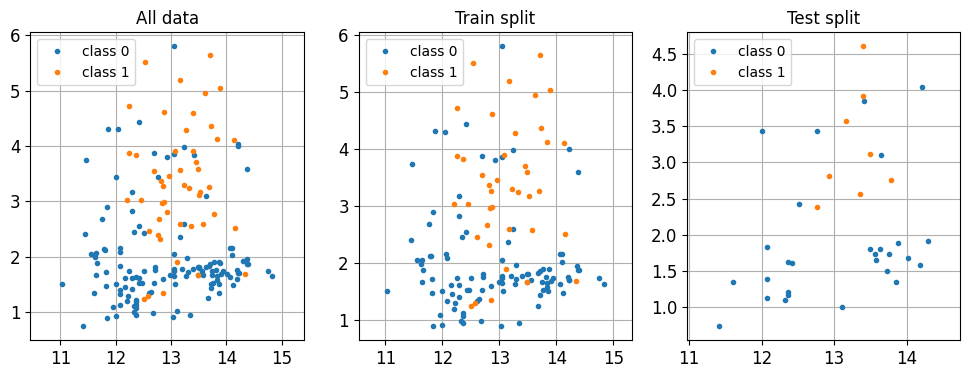

In [167]:
def plot_data(X, y):
    plt.plot(X[y==0,0], X[y==0,1], '.', label='class 0')
    plt.plot(X[y==1,0], X[y==1,1], '.', label='class 1')
    plt.axis('equal')
    plt.grid('on')
    plt.legend()

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plot_data(X, y)
plt.title('All data')

plt.subplot(1,3,2)
plot_data(X_train, y_train)
plt.title('Train split')

plt.subplot(1,3,3)
plot_data(X_test, y_test)
plt.title('Test split')

## 3. Randomness and feature scaling in Stochastic Gradient Descent

We'll explore how the randomness and scaling can affect the result of a classifier trained using SGD.

<div class="alert alert-info">
    <h1>🎥 <a href="https://brightspace.tudelft.nl/d2l/le/content/682421/viewContent/3726352/View">Lecture 3A - Parameter optimization</a></h1>
    The following requires the knowledge covered in this lecture. If you haven't watched the video yet, it's now high time to do so...
</div>

In [168]:
from sklearn.linear_model import SGDClassifier

In [169]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

In [170]:
def print_eval_stats_on_data(clf, X, y):
    y_pred = clf.predict(X)
    print('  accuracy:', accuracy_score(y, y_pred))
    print('  confusion matrix:')
    print(confusion_matrix(y, y_pred))
    print('  f1:', f1_score(y, y_pred))

def print_eval_stats(clf, X_train, y_train, X_test, y_test):
    print('TRAIN')
    print_eval_stats_on_data(clf, X_train, y_train)
    print()

    print('TEST')
    print_eval_stats_on_data(clf, X_test, y_test)
    print()

With the interactive widget below, we can see how the `random_state` parameter of the SGDClassifier affects the classification result. 
The parameter is used when determining the randomness in the process, such as the random initialization and the order of how the samples are processed for gradient computations.

In [171]:
def eval_sgd_random_state(random_state=3):
    sgd_clf = SGDClassifier(random_state=random_state)
    sgd_clf.fit(X_train, y_train);
    
    print('random_state =', random_state)
    print_eval_stats(sgd_clf, X_train, y_train, X_test, y_test)

ipywidgets.interact(eval_sgd_random_state, random_state=(0,49))

interactive(children=(IntSlider(value=3, description='random_state', max=49), Output()), _dom_classes=('widget…

<function __main__.eval_sgd_random_state(random_state=3)>

### 3.1 Write some code to do the following:
1. train the standard `SGDClassifier`, and set its random_state to a random seed. Don't set any other keywords in the constructor, just use the default values.
2. evaluate the classifier on the test data
3. compute the accuracy and F1 score on the test data.

Use this to compute for the first 50 random seeds (0 up to 49) both the mean and standard deviation of the two metrics on the test data.

In [172]:
random_seeds = range(50)

accuracy_scores = []
f1_scores = []

for seed in random_seeds:
    sgd_clf = SGDClassifier(random_state=seed)
    sgd_clf.fit(X_train, y_train)
    y_pred = sgd_clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)

accuracy_mean = np.mean(accuracy_scores)
accuracy_stddev = np.std(accuracy_scores)
f1_mean = np.mean(f1_scores)
f1_stddev = np.std(f1_scores)

print(f'Accuracy: average = {accuracy_mean:.3f}\t(std.dev. = {accuracy_stddev:.3f})')
print(f'      F1: average = {f1_mean:.3f}\t(std.dev. = {f1_stddev:.3f})')

Accuracy: average = 0.749	(std.dev. = 0.122)
      F1: average = 0.358	(std.dev. = 0.235)


In [173]:

assert(isinstance(accuracy_mean, float))
assert(isinstance(accuracy_stddev, float))
assert(isinstance(f1_mean, float))
assert(isinstance(f1_stddev, float))


It is clear that the randomness in the SGD optimization can have a significant impact on the results.

**Q**: you should see that the accuracy is generally pretty good, but the F1 score is quite low and shows more variance. Why is this the case?

Accuracy remains high and stable because it is dominated by the classifier's performance on the majority class (negative class), which it predicts well consistently.
F1 Score is low and variable because it is sensitive to the classifier's performance on the minority class (positive class), which is inconsistent due to:
Class imbalance: The model has less data to learn from for the minority class.
Randomness in training: Different random seeds affect the learning process for the minority class more significantly.
Variance in F1 Score: Indicates that the model's ability to detect the positive class is unstable across different runs, likely due to the reasons above.

### 3.2 Next, let's take a look at what happens when the axes in the feature space are scaled differently.

In [174]:
# create a version of the data with scaled and shifted features
X2 = X.copy()
X2[:,0] *= 4. # scale one feature
X2 += np.array([10., -3.0]) # shift both features

X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)

In [175]:
# NOTE: using the same random state here

# original data
sgd_clf = SGDClassifier(random_state=3)
sgd_clf.fit(X_train, y_train);

# scaled data
sgd_clf2 = SGDClassifier(random_state=3)
sgd_clf2.fit(X2_train, y_train)

print('** Normal')
print_eval_stats(sgd_clf, X_train, y_train, X_test, y_test)

print('** Scaled')
print_eval_stats(sgd_clf, X2_train, y_train, X2_test, y_test)

** Normal
TRAIN
  accuracy: 0.7535211267605634
  confusion matrix:
[[98  4]
 [31  9]]
  f1: 0.33962264150943394

TEST
  accuracy: 0.8055555555555556
  confusion matrix:
[[28  0]
 [ 7  1]]
  f1: 0.2222222222222222

** Scaled
TRAIN
  accuracy: 0.7183098591549296
  confusion matrix:
[[102   0]
 [ 40   0]]
  f1: 0.0

TEST
  accuracy: 0.7777777777777778
  confusion matrix:
[[28  0]
 [ 8  0]]
  f1: 0.0



Now write a function that use sklearn's `StandardScaler` to standardize the given data.
The scaler can determine the mean and standard deviation of the features in the data you fit it on.
Afterwards, it can be used to transform given features, removing the fitted mean, and scale the dimensions such that each has std.deviation of 1.

Note that fitting the scaling is considered part of the **training** process. Consider this when you implement the function: How should the training and testing data be scaled? What can you say on the resulting mean vector of both datasets after standardizing?

In [176]:
from sklearn.preprocessing import StandardScaler

def standardize_my_data(X_train, X_test):
    """ Use the StandardScaler() to standardize the data. 
        Returns the standardized versions of the given training and test data.
    """
    scaler = StandardScaler()
    X_train_standardized = scaler.fit_transform(X_train)
    X_test_standardized = scaler.transform(X_test)
    
    return X_train_standardized, X_test_standardized

In [177]:
# standardize the data using your function
X2_train_standardized, X2_test_standardized = standardize_my_data(X2_train, X2_test)

# retrain the classifier for X2
sgd_clf2.fit(X2_train_standardized, y_train)

# evaluate
print_eval_stats(sgd_clf2, X2_train_standardized, y_train, X2_test_standardized, y_test)

# test that the training data is indeed zero mean
assert(np.all( np.abs(X2_train_standardized.mean(axis=0)) < 1e-10 ))
# test that all the features in the training data have std.dev. of 1
assert(np.all( np.abs(X2_train_standardized.std(axis=0) - 1.0) < 1e-10 ))


TRAIN
  accuracy: 0.7394366197183099
  confusion matrix:
[[93  9]
 [28 12]]
  f1: 0.39344262295081966

TEST
  accuracy: 0.7777777777777778
  confusion matrix:
[[27  1]
 [ 7  1]]
  f1: 0.2



You should see that the results after scaling the data again resemble the earlier results on the original undistorted data, though they may still be a bit different since the original data wasn't standardized either.

Again, even with the same random seed, the scaling of the feature space affects the solution that SGD finds.
Standardizing the data to ensure all feature dimensions are in the same order of magnitude can help.

## 4. Reimplement binary classification metrics

In the practicum assignments we have now used various binary classification metrics, for which sklearn provides builtin solutions for your convenience. Still, any ML practicioner should have a good understanding of what these metrics represent, and should be able to compute these themselves without relying on sklearn.

In this section, reimplement the common binary-classification performance metrics yourself.
Many metrics can be expressed in terms of the number of True Positives (TP), False Positves (FP), True Negatives (TN) and False Negatives (FN) that your classifier obtained.

### 4.1 Therefore, first implement a function that computes these four numbers from the groundtruth labels and your classifier's perdicted labels.
You can assume that y contains integers representing the two class labels, and you should consider the largest label in `y` as the positive class.

In [178]:
def my_tp_fp_tn_fn(y, y_pred):
    positive_label = np.max(y)
    negative_label = np.min(y)
    
    TP = np.sum((y == positive_label) & (y_pred == positive_label))
    FP = np.sum((y != positive_label) & (y_pred == positive_label))
    TN = np.sum((y != positive_label) & (y_pred != positive_label))
    FN = np.sum((y == positive_label) & (y_pred != positive_label))
    
    return (TP, FP, TN, FN)

In [179]:
# Test on some fake predictions and GT labels
y_dummy = np.array([0,0,0,1,1,1,1,1])

y_pred_dummy1 = np.array([0,1,0,0,0,0,1,1])
TP, FP, TN, FN = my_tp_fp_tn_fn(y_dummy, y_pred_dummy1)
assert((TP, FP, TN, FN) == (2,1,2,3))

# all correct
y_pred_dummy2 = np.array([0,0,0,1,1,1,1,1])
TP, FP, TN, FN = my_tp_fp_tn_fn(y_dummy, y_pred_dummy2)
assert((TP, FP, TN, FN) == (5,0,3,0))

# all wrong
y_pred_dummy3 = np.array([1,1,1,0,0,0,0,0])
TP, FP, TN, FN = my_tp_fp_tn_fn(y_dummy, y_pred_dummy3)
assert((TP, FP, TN, FN) == (0,3,0,5))

In [180]:
# Extra point if you make your function work with not only
#    with labels [0, 1], but also with other labels, e.g. [1, 2]

# Test on some fake predictions and GT labels
y_dummy = np.array([0,0,0,1,1,1,1,1])+1 # <---- NOTE the +1

y_pred_dummy1 = np.array([0,1,0,0,0,0,1,1])+1 # <---- NOTE the +1
TP, FP, TN, FN = my_tp_fp_tn_fn(y_dummy, y_pred_dummy1)
assert((TP, FP, TN, FN) == (2,1,2,3))

# all correct
y_pred_dummy2 = np.array([0,0,0,1,1,1,1,1])+1 # <---- NOTE the +1
TP, FP, TN, FN = my_tp_fp_tn_fn(y_dummy, y_pred_dummy2)
assert((TP, FP, TN, FN) == (5,0,3,0))

# all wrong
y_pred_dummy3 = np.array([1,1,1,0,0,0,0,0])+1 
TP, FP, TN, FN = my_tp_fp_tn_fn(y_dummy, y_pred_dummy3)
assert((TP, FP, TN, FN) == (0,3,0,5))

### 4.2 Using these numbers, implement the following metrics:
- Accuracy
- Confusion matrix
- Precision
- Recall
- F1

Notes:
* Remember that these metrics were explained in Chapter 3 of the book.
* Your implementation of these functions should all use the numbers returned from the `my_tp_fp_tn_fn()` function, except for the F1 score, for which you can reuse the results of the `my_precision_score()` and `my_recall_score()`.

In [181]:
def my_accuracy_score(y, y_pred):
    TP, FP, TN, FN = my_tp_fp_tn_fn(y, y_pred)
    accuracy = (TP + TN) / (TP + FP + TN + FN)
    return accuracy

def my_confusion_matrix(y, y_pred):
    TP, FP, TN, FN = my_tp_fp_tn_fn(y, y_pred)
    confusion_matrix = np.array([[TN, FP], [FN, TP]])
    return confusion_matrix

def my_precision_score(y, y_pred):
    TP, FP, TN, FN = my_tp_fp_tn_fn(y, y_pred)
    precision = TP / (TP + FP)
    return precision

def my_recall_score(y, y_pred):
    TP, FP, TN, FN = my_tp_fp_tn_fn(y, y_pred)
    recall = TP / (TP + FN)
    return recall

def my_f1_score(y, y_pred):
    precision = my_precision_score(y, y_pred)
    recall = my_recall_score(y, y_pred)
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

In [182]:
# get some classification results for reference
sgd_clf = SGDClassifier(random_state=4)
sgd_clf.fit(X_train, y_train)
y_train_pred = sgd_clf.predict(X_train)
y_test_pred = sgd_clf.predict(X_test)

# run defaul implementation
sklearn_confmat = confusion_matrix(y_train, y_train_pred)
sklearn_accuracy = accuracy_score(y_train, y_train_pred)
sklearn_precision = precision_score(y_train, y_train_pred)
sklearn_recall = recall_score(y_train, y_train_pred)
sklearn_f1 = f1_score(y_train, y_train_pred)

print('*** SKLEARN IMPLEMENTATION ***')
print(f' confusion matrix:')
print(sklearn_confmat)
print(f' accuracy: {sklearn_accuracy:.3f}')
print(f'precision: {sklearn_precision:.3f}')
print(f'   recall: {sklearn_recall:.3f}')
print(f'       f1: {sklearn_f1:.3f}')
print()

# run student implementation
my_confmat = my_confusion_matrix(y_train, y_train_pred)
my_accuracy = my_accuracy_score(y_train, y_train_pred)
my_precision = my_precision_score(y_train, y_train_pred)
my_recall = my_recall_score(y_train, y_train_pred)
my_f1 = my_f1_score(y_train, y_train_pred)

print('*** YOUR IMPLEMENTATION ***')
print(f' confusion matrix:')
print(my_confmat)
print(f' accuracy: {my_accuracy:.3f}')
print(f'precision: {my_precision:.3f}')
print(f'   recall: {my_recall:.3f}')
print(f'       f1: {my_f1:.3f}')
print()

assert(np.all(my_confmat == sklearn_confmat))
assert(np.all(my_accuracy == sklearn_accuracy))
assert(np.all(my_precision == sklearn_precision))
assert(np.all(my_recall == sklearn_recall))
assert(np.all(my_f1 == sklearn_f1))

*** SKLEARN IMPLEMENTATION ***
 confusion matrix:
[[98  4]
 [33  7]]
 accuracy: 0.739
precision: 0.636
   recall: 0.175
       f1: 0.275

*** YOUR IMPLEMENTATION ***
 confusion matrix:
[[98  4]
 [33  7]]
 accuracy: 0.739
precision: 0.636
   recall: 0.175
       f1: 0.275



## 5. Decision boundaries in the feature space

In sklearn, we can evaluate the continuous hypothesis function of a trained classifier using the `decision_function(x)` member function of the classifier object.
Since we are using a 2D feature space, we can try to map the shape of this hypothesis function, and the resulting decision boundary, by evaluating these functions at a fixed number of grid points in the feature space.

In [183]:
def plot_feature_space_function(X, y, f, res=0.1):
    """ Plot the 2D feature space of the first two features of the data in X.
        For the feature space, plot the samples in X with their class labels y,
        and also overlay a countour plot with the function f(x) evaluated at a grid within
        the shown region of the feature space (the size of the region is determined by the extent of the data).
        based on https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_decision_regions.html
    """

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, res),
                         np.arange(y_min, y_max, res))

    Z = f(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.plot(X[y==0,0], X[y==0,1], '.', label='class 0')
    plt.plot(X[y==1,0], X[y==1,1], '.', label='class 1')
    plt.grid('on')
    plt.legend()


### 5.1 Linear classifier
We will first train a linear classifier again

In [184]:
sgd_clf = SGDClassifier(random_state=10)
sgd_clf.fit(X, y);

Text(0.5, 1.0, 'prediction label')

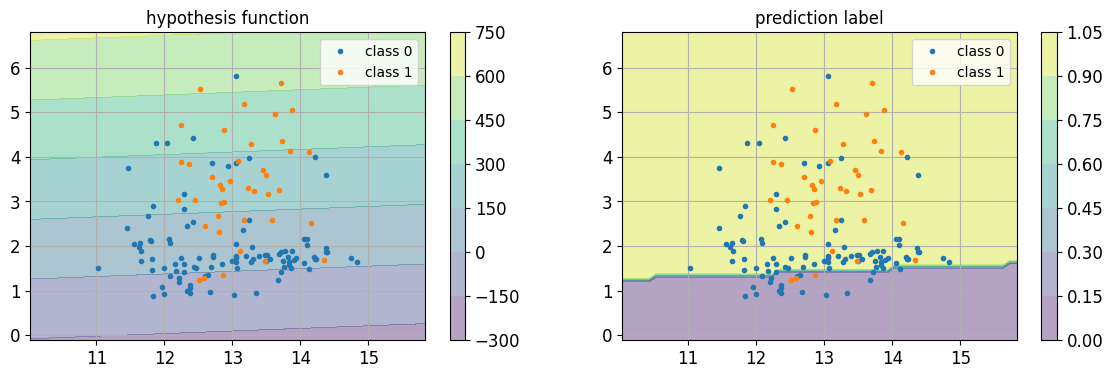

In [185]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plot_feature_space_function(X_train, y_train, sgd_clf.decision_function)
plt.colorbar() # colorbar shows the signed distance to the separating hyperplane.
plt.title('hypothesis function')

plt.subplot(1,2,2)
plot_feature_space_function(X_train, y_train, sgd_clf.predict)
plt.colorbar() # although the colorbar ranges from 0 to 1.05, the predicted label can only be 0 or 1 here (binary classification).
plt.title('prediction label')

Evaluating a linear classifier

Now let's see if you can reproduce these figures 'manually' by reimplementing the hypothesis function of the linear classifier yourself.
We will not focus here on training the linear classifier, so we will reuse the the trained sklearn classifier.

#### Math
Given 
* a feature vector $x = [x_1, x_2, ..., x_D]$,
* and model parameters $[w_1, ..., w_D, b]$,

Then for a linear classifier
* the hypothesis is $h(x) = \sum_i [ x_i . w_i ] + b$
* the predicted label $\widehat{y}$ is
  * `0` if $h(x) < 0.$
  * `1` if $h(x) >= 0.$

Note that the summation in the hypothesis function can be implented efficiently using a dot product.

#### Task
Create the following functions:

1. `my_lin_decision_function(sgd_clf, X)` should evaluate the hypothesis function of the linear classifier on the data in matrix X (each row is one feature vector). The outcome of this function should be the same as when calling `sgd_clf.decision_function(X)`

2. `my_lin_predict(sgd_clf, X)` should return the predicted class labels for the data X, the result should be the same as when calling `sgd_clf.predict(X)`. To implement this function, first get the result of `my_lin_decision_function(sgd_clf, X)`. Assume that the negative class has label `0`, and the positive class has label `1`.


**Tip:**
In the first step you should extract the learned model weights from the trained sklearn classifier. Look in [the documentation of SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html?highlight=sgdclassifier#sklearn.linear_model.SGDClassifier) for the list of "Attributes" that the trained object will have, here you will find the name of the model weights vector $w$ and of the offset $b$ (a.k.a. "intercept"). 


In [186]:
def my_lin_decision_function(sgd_clf, X):
    # Extract the learned model weights and offset from the trained sklearn classifier
    weights = sgd_clf.coef_
    offset = sgd_clf.intercept_
    
    # Calculate the dot product of the weights and the input data, adding the offset
    # Ensure the weights are reshaped correctly for the dot product
    y = np.dot(X, weights.T) + offset
    
    # Correctly handle the case where the intercept is a vector (for multi-class classification)
    if offset.ndim == 1:
        y = y[:, 0]  # Select the first column for binary classification
    else:
        y = y[:, 0]  # Select the first column for binary classification
    
    return y

def my_lin_predict(sgd_clf, X):
    # First, get the result of my_lin_decision_function(sgd_clf, X)
    decision = my_lin_decision_function(sgd_clf, X)
    
    # Predict the class labels based on the decision function output
    y = (decision >= 0).astype(int)
    
    return y

In [187]:
my_decision = my_lin_decision_function(sgd_clf, X)
sklearn_decision = sgd_clf.decision_function(X)

assert(my_decision.shape == sklearn_decision.shape)
assert(np.all(np.abs(my_decision - sklearn_decision) < 1e-12))

my_predict = my_lin_predict(sgd_clf, X)
sklearn_predict = sgd_clf.predict(X)

assert(my_predict.shape == sklearn_predict.shape)
assert(np.all(my_predict == sklearn_predict))


If you have implemented the classifier correctly, the following block should generate the same feature space plots as we made before with sklearn's builtin functions. Verify that the plots are indeed the same.

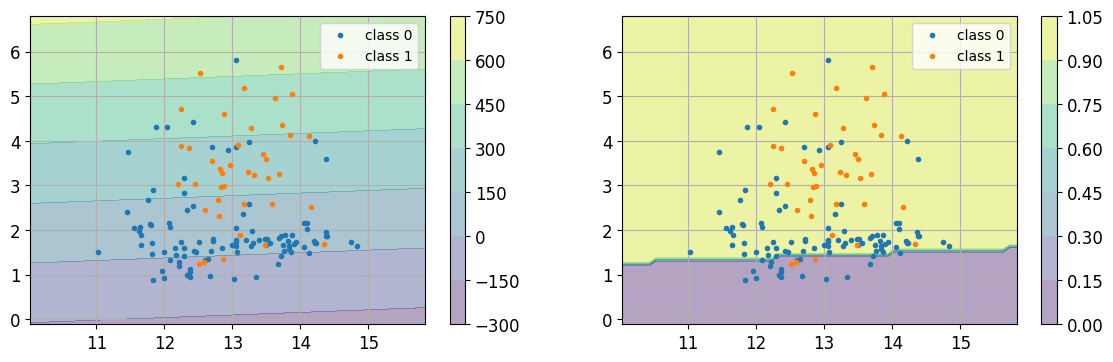

In [188]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plot_feature_space_function(X_train, y_train, lambda X: my_lin_decision_function(sgd_clf, X))
plt.colorbar()

plt.subplot(1,2,2)
plot_feature_space_function(X_train, y_train, lambda X: my_lin_predict(sgd_clf, X))
plt.colorbar() 

### 5.2 Define a Bayesian classifier

<div class="alert alert-info">
    <h1>🎥 <a href="https://brightspace.tudelft.nl/d2l/le/content/682421/viewContent/3726354/View">Lecture 3B - Generative models</a></h1>
    The following requires the knowledge covered in this lecture. If you haven't watched the video yet, it's now high time to do so...
</div>

#### 5.2.1 As the first step, let's estimate the prior class probability distribution $p(y)$.
Since this is a distribution over only two possible discrete outcomes, $y=0$ and $y=1$,
we can characterize this distributions by an array $p = [p0, p1]$ with two element, i.e.

- $p0 = p(y=0)$ is the prior probability that the a sample's class label is 0
- $p1 = p(y=1)$ is the prior probability that the a sample's class label is 1

Of course, $p0 + p1 = 1$, since these are the only possible labels.
Implement a function that computes the array $p$.

In [189]:
def estimate_prior(y):
    unique, counts = np.unique(y, return_counts=True)
    prior = counts / counts.sum()
    return prior


In [190]:
prior = estimate_prior(y)

print('Prior:')
print('    p(y=0):', prior[0])
print('    p(y=1):', prior[1])

assert(len(prior) == len(np.unique(y)))
assert(np.all( prior >= 0. ))
assert(np.all( prior <= 1. ))
assert(np.sum(prior) == 1. )


Prior:
    p(y=0): 0.7303370786516854
    p(y=1): 0.2696629213483146


#### 5.2.2 In the next step, define the likelihood term, which is the class conditional probability $p(x|y)$.
We will use here a single 2D multivariate Gaussian distribution, i.e. $p(x|y=c) = N(x | \mu_c, \Sigma_c)$.
This means that we need to estimate two parameters per class $c$:
- the 2D mean feature vector for the class, $\mu_c$
- the $2 \times 2$ covariance matrix $\Sigma_c$

These are common statistical properties that can be computed using standard numpy functions, e.g. `mean()` and `cov()`.

**Note** the [numpy.cov documentation](https://numpy.org/doc/stable/reference/generated/numpy.cov.html) that the covariance is normally computed "without bias". This concept of bias in the covariance computation is a statistical notion, and related to the fact if we assume that we already know the mean or not. 
It is beyond the scope of this assignment to go in more detail on this difference now, but you should compute the covariance **with bias** since we *do* already compute the mean, so pass `bias=True` to the `cov()` function.

In [191]:
def estimate_gauss2d_class_likelihood(X, y, c):
    """ Estimate the parameters of a 2D multivariate Gaussian for class c.
        Input   : X, a N x D matrix of N features in D-dimensional feature space
        Input   : y, a N-dimensional array with the class labels of data X
        Input   :  c, the target class label, either 0 or 1, for which we want to compute the parameters
        Returns : (mean, cov), a tuple consisting of
                     2-dimensional mean vector of the data for class label c
                     2x2 covariance matrix of the data for class label c
    """
    # Filter the data for the specified class
    class_data = X[y == c]
    
    # Calculate the mean vector
    mean = np.mean(class_data, axis=0)
    
    # Calculate the covariance matrix with bias
    cov = np.cov(class_data, rowvar=False, bias=True)
    
    return mean, cov

In [192]:
# here we estimate the Gaussian distributions for the class labels
means = [None, None]
covs = [None, None]
for c in [0, 1]:
    means[c], covs[c] = estimate_gauss2d_class_likelihood(X, y, c)

# perform some checks
assert(means[0].shape == (2,))
assert(means[1].shape == (2,))
assert(covs[0].shape == (2,2))
assert(covs[1].shape == (2,2))
# covariance matrices should be symmetric
assert(np.all( covs[0].T == covs[0] ))
assert(np.all( covs[1].T == covs[1] ))


Let's visualize the estimated parameters. Below you are given a small utility function that can plot the parameters of a 2D Gaussian as ellipses that separate the high probability density region (inside the ellipse) from the low probability density region (outside the ellipse). If everything is correct, the block below should generate the same image.

![reference plot of fitted parameters](extra/reference_plot_gauss_fit.png)

Text(0.5, 1.0, 'fitted 2D Gauss for class 1')

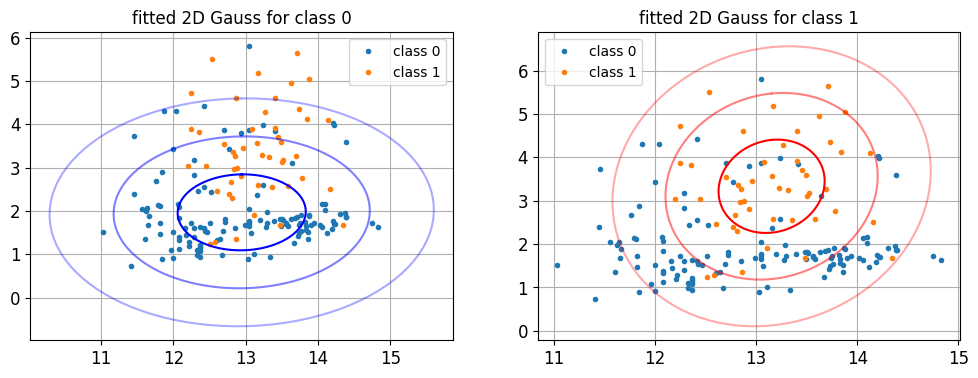

In [193]:
def plot_gauss(mean, cov, sigmas=None, *args, **kwargs):
    """ Plot the 2D Gaussian distribution as an ellipse.
        The ellipse marks the points with equal probability density.
        The width is indicate by sigma, which for a 1D gauss would be
        the probability density at 1 std.dev. away from the mean.
        Multiple ellipses can be drawn if multiple sigma values are given.
    """
    if sigmas is None:
        sigmas = [1.]
    
    S = np.linalg.cholesky(cov)
    alphas = np.linspace(0, np.pi*2, 100)
    xs = np.vstack((np.sin(alphas), np.cos(alphas)))
    xs = S.dot(xs).T
    for s in sigmas:
        pts = xs*s + mean
        plt.plot(pts[:,0], pts[:,1], alpha=1./s, *args, **kwargs)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)

plt.plot(X[y==0,0], X[y==0,1], '.', label='class 0')
plt.plot(X[y==1,0], X[y==1,1], '.', label='class 1')
plot_gauss(means[0], covs[0], color='b', sigmas=[1., 2., 3.])
# plot_gauss(means[0], covs[0], sigmas=[1., 2., 3.])
plt.legend()
plt.grid('on')
plt.title('fitted 2D Gauss for class 0')

plt.subplot(1,2,2)

plt.plot(X[y==0,0], X[y==0,1], '.', label='class 0')
plt.plot(X[y==1,0], X[y==1,1], '.', label='class 1')
plot_gauss(means[1], covs[1], color='r', sigmas=[1., 2., 3.])
plt.legend()
plt.grid('on')
plt.title('fitted 2D Gauss for class 1')


#### 5.2.3 Next, we must be able to evaluate these class-conditional probabilities $p(x|y=c)$ for any other point $x$ in the feature space, for each class $y=c$.
To achieve this, we need to evaluate the probability density function of the multivariate Gaussian,

$p(x|y=c) = N(x | \mu_c, \Sigma_c)$

where the Gaussian density function is defined as
$N(x | \mu_c, \Sigma_c) = \frac{1}{\sqrt{(2\pi)^d |\Sigma|}} e^{-\frac{1}{2}(x-\mu)^\top \Sigma^{-1} (x-\mu)}$.

Luckily, this function is already implemented in the `stats` module of the scipy library,
so you will only need to wrap this [multivariate_normal.pdf()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html#scipy-stats-multivariate-normal) function.


In [194]:
def class_likelihood(X, c, means, covs):
    """ Compute the multivatiate Gaussian pdf on data X for class c.
        Input:     X, a N x D matrix of N features in D-dimensional feature space
        Input:     c, the target class label, either 0 or 1
        Input: means, list with mean vectors of classes 0 and 1
        Input:  covs, list with cocariance matrices of classes 0 and 1
        Returns:   p, a N-dimensional array with the probability density of the N features for the given class c
    """
    from scipy.stats import multivariate_normal
    # Select the mean and covariance for the specified class
    mean = means[c]
    cov = covs[c]
    # Create a multivariate normal distribution object
    distribution = multivariate_normal(mean=mean, cov=cov)
    # Evaluate the probability density function for each data point in X
    p = distribution.pdf(X)
    return p


In [195]:
# we should be able to evaluate these function for both classes
p0 = class_likelihood(X, 0, means, covs)
p1 = class_likelihood(X, 1, means, covs)

# each call should return N probability densities
assert(p0.shape == (X.shape[0],))
assert(p1.shape == (X.shape[0],))

# probability densities should be positive
#   NOTE: no guarantee that they are below 1, or that they sum to 1. A probability densitiy is NOT the same thing is a probability
assert(np.all( p0 >= 0. ))
assert(np.all( p1 >= 0. ))


If you implemented the function correctly, we should now be able to visualize the probability density for each class for each point in the space. We can reuse the function `plot_feature_space_function` to show the density using a colored overlay. The changes in the colored regions should show the same contours in the plots you made a few cells above.

The cell block below should show the same plot as this:
![reference plot of fitted parameters](extra/reference_plot_gauss_density.png)

Text(0.5, 1.0, 'likelihood p(x|y=1)')

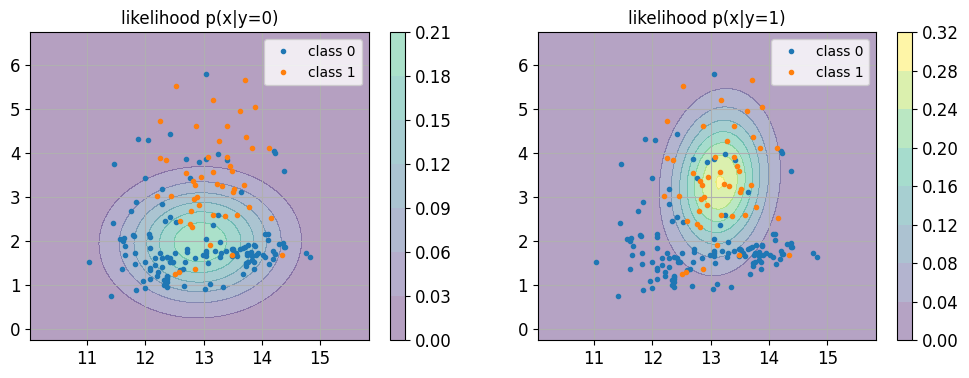

In [196]:
def eval_lik_c0(X):
    return class_likelihood(X, 0, means, covs)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plot_feature_space_function(X, y, eval_lik_c0)
plt.clim([0, 0.3]) # fix intensity scale
plt.colorbar()
plt.title('likelihood p(x|y=0)')

def eval_lik_c1(X):
    return class_likelihood(X, 1, means, covs)

plt.subplot(1,2,2)
plot_feature_space_function(X, y, eval_lik_c1)
plt.clim([0, 0.3])
plt.colorbar()
plt.title('likelihood p(x|y=1)')

#### 5.2.4 Now that we can estimate the parameters of our prior and likelihood terms,
we need to implement the functions to evaluate the posterior.
The posterior can be found using Bayes' rule.
In particular, we are interested in the posterior probability of the positive class (i.e. $y = 1$),
which with Bayes' rule is computed as

$ p(y=1|x) = \frac{p(x|y=1) p(y=1)}{p(x|y=0) p(y=0) + p(x|y=1) p(y=1)}$

Implement the function `class_posterior()`, which should compute this posterior probability $p(y=1|x)$ for all the feature vectors in X.
The given function `bayes_classifier_predict()` should accordingly return the class label `1` when the posterior for $y=1$ is more probable, i.e. at least 50%. Otherwise it will return the label `0`.

Reuse the function `class_likelihood()` that you wrote before.

In [197]:
def class_posterior(X, prior, means, covs):
    """ Compute posterior probability for class y = 1 for all feature vectors in X
        Input  : X, a N x D matrix of N features in D-dimensional feature space
        Input  : prior, an array with the prior probabilities of class 0 and 1
        Input  : means, list with mean vectors of classes 0 and 1
        Input  : covs, list with covariance matrices of classes 0 and 1
        Returns: post, a N-dimensional vector containing the posterior probabilities of y=1 for the given features.
    """
    # Compute likelihoods for both classes
    lik_c0 = class_likelihood(X, 0, means, covs)
    lik_c1 = class_likelihood(X, 1, means, covs)
    
    # Compute the denominator for Bayes' rule
    denominator = lik_c0 * prior[0] + lik_c1 * prior[1]
    
    # Compute the posterior probability for class 1
    post = (lik_c1 * prior[1]) / denominator
    
    return post

def bayes_classifier_predict(X, prior, means, covs):
    # Compute the posterior probability for class 1
    post = class_posterior(X, prior, means, covs)
    
    # Predict class 1 if posterior probability is at least 50%
    predictions = post >= 0.5
    
    return predictions


In [198]:
p = class_posterior(X, prior, means, covs)

# this should contain the probability for class y = 1
assert(p.shape == (X.shape[0],))
assert(np.all( p >= 0. )) 
assert(np.all( p <= 1. )) # this should hold, since probability, not probability density


As a last check, let's plot all the steps together to highlight how the decision boundary is constructed.

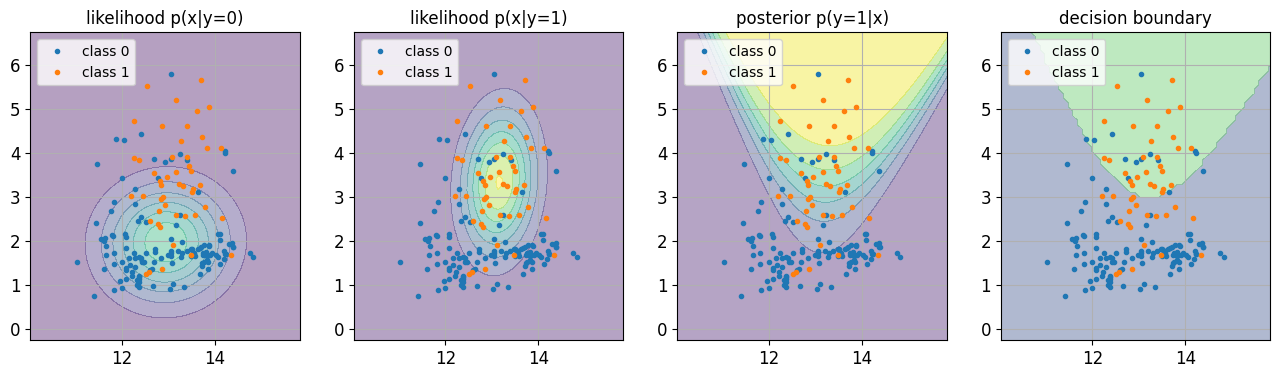

In [199]:
def eval_lik_c0(X):
    return class_likelihood(X, 0, means, covs)

plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
plot_feature_space_function(X, y, eval_lik_c0)
plt.clim([0, 0.3]) # fix intensity scale
#plt.colorbar()
plt.title('likelihood p(x|y=0)')

def eval_lik_c1(X):
    return class_likelihood(X, 1, means, covs)

plt.subplot(1,4,2)
plot_feature_space_function(X, y, eval_lik_c1)
plt.clim([0, 0.3])
#plt.colorbar()
plt.title('likelihood p(x|y=1)')

def eval_posterior(X):
    return class_posterior(X, prior, means, covs)

plt.subplot(1,4,3)
plot_feature_space_function(X, y, eval_posterior)
plt.clim([0, 1.0]) # fix intensity scale
#plt.colorbar()
plt.title('posterior p(y=1|x)');

def eval_predict(X):
    return bayes_classifier_predict(X, prior, means, covs)

plt.subplot(1,4,4)
plot_feature_space_function(X, y, eval_predict)
plt.clim([0, 1.0]) # fix intensity scale
#plt.colorbar()
plt.title('decision boundary');

### 5.3 Creating a new sklearn Classifier

Now that we have performed all these steps in isolation, let's join them into a custom sklearn classifier class.
This is done by subclassing sklearn's `BaseEstimator` and `ClassifierMixin`,
as is explained in more detail [in the sklearn documentation on rolling your own classifier](https://scikit-learn.org/stable/developers/develop.html#rolling-your-own-estimator).
We have already given you the main skeleton in the cell below, though.

A few notes:

- sklearn provides some utility functions for common checks, such as `check_X_y(X,y)` to test if training data X and y have the right shape and format (otherwise an exception will be thrown, alerting the user). These utility functions have already been added for your convenience.


- Do not do any data or parameter validation in the initializer, only do this is in the fit() member function. See [parameters and init in the sklearn documentation](https://scikit-learn.org/stable/developers/develop.html#parameters-and-init) for more info on why. Since our Bayesian classifier doesn't have any hyperparameters at all, the initialization function can remain empty (we still need a `pass` statement which does nothing to make it legal python code though with proper identation)

- Like we have seen with the SGDClassifier before, sklearn has the convention that trained model parameters terminate with a single underscore '\_'. So call your members `self.prior_` instead of `self.prior`, for instance. 

In [200]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class MyBayesClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        # do NOT do anything in the initializer
        pass
    
    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        
        # Assuming the implementation of the Bayesian classifier's fit method
        # This is a placeholder for the actual implementation
        self.prior_ = np.mean(y)  # Example: calculate prior probability
        self.means_ = np.mean(X, axis=0)  # Example: calculate mean for each feature
        self.covs_ = np.cov(X.T)  # Example: calculate covariance matrix
        
        return self
    
    def predict(self, X):
        
        # Check is fit had been called
        check_is_fitted(self)
        
        # Input validation
        X = check_array(X)
        
        # Assuming the implementation of the Bayesian classifier's predict method
        # This is a placeholder for the actual implementation
        y_pred = np.zeros(X.shape[0])  # Initialize prediction array
        for i, x in enumerate(X):
            # Example: calculate the posterior probability for each sample
            posterior = self.prior_ * np.exp(-0.5 * np.dot(np.dot((x - self.means_).T, np.linalg.inv(self.covs_)), (x - self.means_)))
            y_pred[i] = posterior > 0.5  # Example: threshold for binary classification
        
        return y_pred


In [201]:
bayes_gauss_clf = MyBayesClassifier()

# this should work
bayes_gauss_clf.fit(X, y)
y_pred = bayes_gauss_clf.predict(X)


# when X and y do not have the right format, a ValueError should be thrown.
#    (this should be done automatically if you left the check_X_y() call in place)
def should_throw_exception(f):
    """ test if function f throws the expected exception """
    try:
        f()
    except:
        return True
    else:
        return False

# wrong input should throw an exception    
assert( should_throw_exception(lambda : bayes_gauss_clf.fit(X.T, y)) )

# predicting with a non-fitted object should throw an exception
clf_not_fitted = MyBayesClassifier()
assert( should_throw_exception(lambda : clf_not_fitted.predict(X)) )




Now your Bayesian classifer should be compatible with most sklearn utilities,
and we can use the same `.fit()` and `.predict()` interface as before.

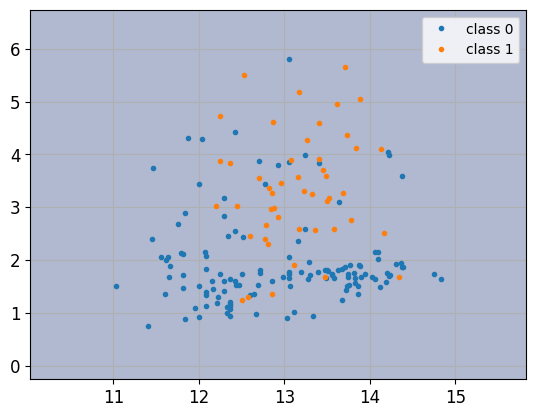

In [202]:
bayes_gauss_clf = MyBayesClassifier()
bayes_gauss_clf.fit(X, y)

plot_feature_space_function(X, y, bayes_gauss_clf.predict)

### 5.4 Create a Gaussian-Mixture Bayesian classifier

The Bayesian classifier you just wrote used a single multi-variate Gaussian to represent each class's data distribution. However, this is a pretty strong assumption on the shape of the class data.
We can make a more flexible classifier by describing each class's data instead with a different more complex distribution. If we can fit this complex distribution, and evaluate its probability density for new feature vectors, we can still plug it in the Bayesian formulation and compute a class posterior distribution as before.


A general method to approximate non-Gaussian distributions is to use not 1 but multiple Gaussians, each with their own mean and covariance. The full distribution is then a weighted combinations of these separate Gaussian components. Such a distribution is called a **Gaussian Mixture**.

This figure shows *left* a classifier using a Gaussian per class (like you wrote before),
and *right* a classifier using per-class a Gaussian Mixture with 2 components.
![Gaussian vs Gaussian-Mixture classier](extra/gaussian_vs_mixture_classifier.png)

### fitting a Gaussian Mixture distribution
Unlike with a single Gaussian, where model parameters can be directly computed in closed form, fitting a Gaussian Mixture requires an iterative optimization scheme. This scheme iterates between two steps:
1. figuring out which data points are covered by which Gaussian component
2. fit the Gaussian components on the data points that they cover.

After the parameters of the Gaussian Mixture have been altered in step 2, the Gaussian components may cover the data slightly differently, hence the next iteration must start again with step 1.

### using sklearn's Gaussian Mixture

Luckily, the `sklearn.mixture` module contains a ready made `GaussianMixture` class that can be used to fit a Gaussian Mixture distribution on given data:

- initialize a Gaussian mixture with $n$ mixture components using `gmm = GaussianMixture(n_components=n)` 
- fit the GMM distribution on data `X` using the iterative method through the object `gmm.fit(X)` function (should be pretty quick for low-dimensional data). Note that you *don't* pass any class labels `y` since the GaussianMixture is not a classifier or regressor, but just an (unsupervised) density estimator.
- you can evaluate the **log** probability density for features `X` using the `gmm.score_samples(X)` member function. Note that because this is the log density, the returned values can be negative.

In [203]:
from sklearn.mixture import GaussianMixture

To better understand how the Gaussian Mixture works, let's play around with it and visualize the components

In [204]:
# create some more dummy data to demonstrate a Gaussian Mixture
from sklearn.datasets import make_blobs
X_, y_ = make_blobs(n_samples=200, centers=4, n_features=2, random_state=0)
y_[:] = 0 # ignore the class labels in our visualization


interactive(children=(IntSlider(value=3, description='n_components', max=7, min=1), Output()), _dom_classes=('…

<function __main__.demo_gmm(n_components=3)>

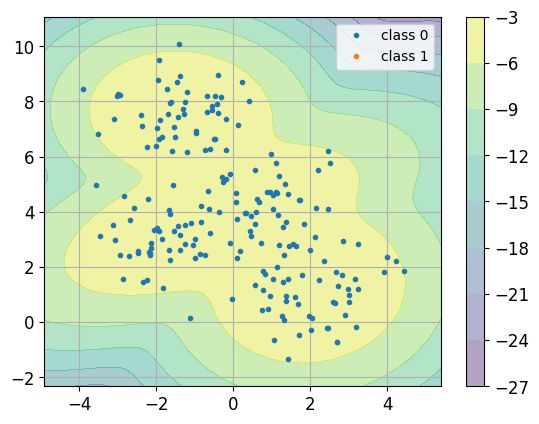

In [205]:
def demo_gmm(n_components=3):
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(X_)

    plot_feature_space_function(X_, y_, gmm.score_samples)
    plt.colorbar()
    
ipywidgets.interact(demo_gmm, n_components=(1,7))

We can also visualize the individual component in the Gaussian mixture to better illustrate how the overall distribution's density is composed of these components.

interactive(children=(IntSlider(value=3, description='n_components', max=7, min=1), Output()), _dom_classes=('…

<function __main__.demo_gmm2(n_components=3)>

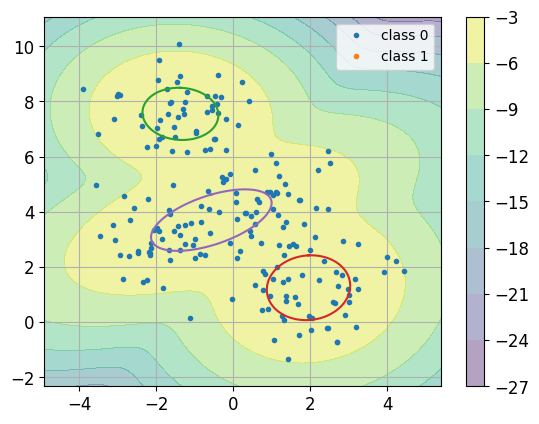

In [206]:
def plot_gmm(gmm, sigmas=None, *args, **kwargs):
    K = gmm.means_.shape[0]
    for k in range(K):
        mean = gmm.means_[k]
        cov = gmm.covariances_[k]
        plot_gauss(mean, cov, sigmas=sigmas, *args, **kwargs)

def demo_gmm2(n_components=3):
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(X_)

    plot_feature_space_function(X_, y_, gmm.score_samples)
    plot_gmm(gmm)
    plt.colorbar()
    
ipywidgets.interact(demo_gmm2, n_components=(1,7))

#### 5.4.1 Now implement a Gaussian Mixture Model (GMM) classifier in the cell below.
You can look at your `MyBayesClassifier` class above, and follow the same steps.

Some hints:
- you can reuse the `estimate_prior()` function, since the formulation of the prior is unaffected by the change
- you should NOT use your `estimate_gauss2d_class_likelihood()` and `class_likelihood()` functions anymore, since these was specificly made for a single 2D Gaussian. Instead store for each class a `GaussianMixture()` object in your fit step, and use its `score_samples()` function to compute the likelihood term in the predict step.
- Note that `GaussianMixture.score_samples` return a *log* probability density, you should apply `np.exp()` to get a regular probability density for your posterior calculation.
- because you can't reuse your `class_likelihood()` function, you also can't reuse your previous `bayes_classifier_predict()` function.
- you can use the `.fit()` function.

In [207]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array

def estimate_prior(y):
    unique, counts = np.unique(y, return_counts=True)
    prior = counts / counts.sum()
    return prior

class MyGmmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_components=1):
        self.n_components = n_components
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.classes_ = np.unique(y)
        self.prior_ = estimate_prior(y)
        self.gmms_ = {}
        from sklearn.mixture import GaussianMixture
        
        for idx, c in enumerate(self.classes_):
            X_c = X[y == c]
            gmm = GaussianMixture(n_components=self.n_components, covariance_type='full', reg_covar=1e-6)
            gmm.fit(X_c)
            self.gmms_[c] = gmm
        return self
    
    def predict(self, X):
        X = check_array(X)
        if not hasattr(self, "gmms_"):
            raise ValueError("This MyGmmClassifier instance is not fitted yet. Call 'fit' before using this estimator.")
        
        posterior_numerators = []
        for idx, c in enumerate(self.classes_):
            gmm = self.gmms_[c]
            log_likelihood = gmm.score_samples(X)
            likelihood = np.exp(log_likelihood)
            posterior_numerator = likelihood * self.prior_[idx]
            posterior_numerators.append(posterior_numerator)
        
        posterior_numerators = np.column_stack(posterior_numerators)
        denominator = np.sum(posterior_numerators, axis=1, keepdims=True)
        denominator[denominator == 0] = 1e-9
        posterior_probs = posterior_numerators / denominator
        y_pred_idx = np.argmax(posterior_probs, axis=1)
        y_pred = self.classes_[y_pred_idx]
        return y_pred


In [208]:
gmm_clf = MyGmmClassifier(n_components=2)

# This should work
gmm_clf.fit(X, y)
y_pred = gmm_clf.predict(X)



# when X and y do not have the right format, a ValueError should be thrown.
#    (this should be done automatically if you left the check_X_y() call in place)
def should_throw_exception(f):
    """ test if function f throws the expected exception """
    try:
        f()
    except:
        return True
    else:
        return False

# wrong input should throw an exception    
assert( should_throw_exception(lambda : gmm_clf.fit(X.T, y)) )

# predicting with a non-fitted object should throw an exception
# because your predict() step should be accessing the not yet set attributes with model parameters
clf_not_fitted = MyGmmClassifier(n_components=2)
assert( should_throw_exception(lambda : clf_not_fitted.predict(X)) )

# The GMM with 1 component should give the same
#   predictions as the original single Gaussian Bayesian classifier
gmm_clf = MyGmmClassifier(n_components=1)
gmm_clf.fit(X, y)
gmm_y_pred = gmm_clf.predict(X)
bayes_gauss_clf = MyBayesClassifier()
bayes_gauss_clf.fit(X, y)
gauss_y_pred = bayes_gauss_clf.predict(X)
assert(np.all( gmm_y_pred == gauss_y_pred))



AssertionError: 

#### 5.4.2 Let's visualize the classification boundary of the Gaussian-Mixture Bayesian classifier
when using 1 or 3 components per class.

For reference, we also show again the boundary of the first (non-mixture) Bayesian classifier you created.

Text(0.5, 1.0, 'GMM, 3 components per class')

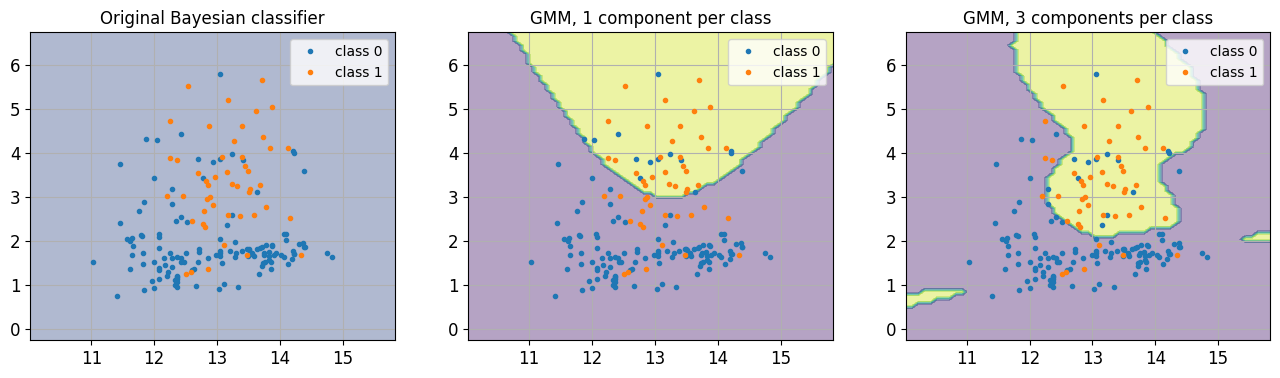

In [140]:
bayes_gauss_clf = MyBayesClassifier()
bayes_gauss_clf.fit(X, y)

gmm1_clf = MyGmmClassifier(n_components=1)
gmm1_clf.fit(X, y)

gmm3_clf = MyGmmClassifier(n_components=3)
gmm3_clf.fit(X, y)


plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plot_feature_space_function(X, y, bayes_gauss_clf.predict)
plt.title('Original Bayesian classifier')

plt.subplot(1,3,2)
plot_feature_space_function(X, y, gmm1_clf.predict)
plt.title('GMM, 1 component per class')

plt.subplot(1,3,3)
plot_feature_space_function(X, y, gmm3_clf.predict)
plt.title('GMM, 3 components per class')

If everything is correct, the GMM with 1 component per class should show the same boundary as your first classifier (Try to answer for yourself: why should these be the same?).

### 5.5 Visually understanding model complexity, overfitting, Bias & Variance

<div class="alert alert-info">
    <h1>🎥 <a href="https://brightspace.tudelft.nl/d2l/le/content/682421/viewContent/3726353/View">Watch Lecture 3C - Model complexity</a></h1>
    The following requires the knowledge covered in this lecture. If you haven't watched the video yet, it's now high time to do so...
</div>

In [141]:
from sklearn import datasets

# Take a dataset, alter it a little bit to make it more interesting ;)
ds = datasets.load_wine()
X = ds['data']
X = X[:,:2]
y = ds['target']
y = (y == 2).astype(np.int32)

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=10)

In [143]:
def show_train_test_feature_space(clf, res=0.05):
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    
    plt.figure(figsize=(14,4))
    plt.subplot(1,2,1)
    plot_feature_space_function(X_train, y_train, clf.predict, res=res)
    plt.title(f'Train split, accuracy {train_acc:.3f}, f1 {train_f1:.3f}')
    
    plt.subplot(1,2,2)
    plot_feature_space_function(X_test, y_test, clf.predict, res=res)
    plt.title(f'Test split, accuracy = {test_acc:.3f}, f1 {test_f1:.3f}')


interactive(children=(IntSlider(value=1, continuous_update=False, description='k', max=25, min=1, step=2), Out…

<function __main__.show_knn_train_test(k=1)>

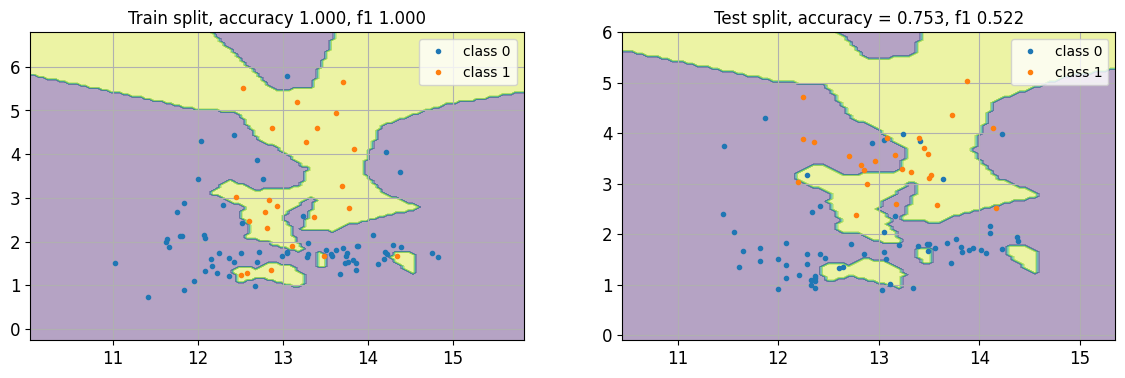

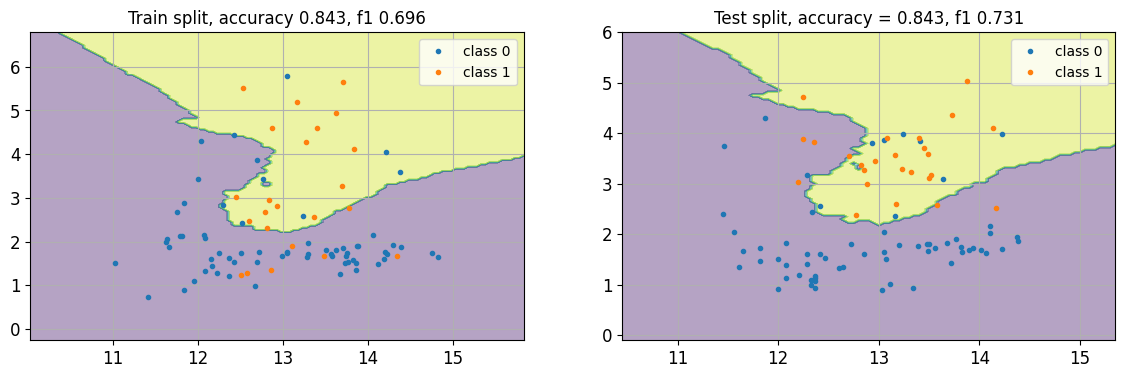

In [144]:
from sklearn.neighbors import KNeighborsClassifier

def show_knn_train_test(k=1):
    print(k)
    knn_clf = KNeighborsClassifier(k)
    knn_clf.fit(X_train, y_train)
    show_train_test_feature_space(knn_clf, res=0.05)

ipywidgets.interact(show_knn_train_test, k=ipywidgets.IntSlider(value=1,min=1, max=25,step=2, continuous_update=False))

#### 5.5.1 Using the interactive widget above, explore how the hyperparameter $k$ affects the decision boundary of the k-Nearest Neighbor classifier.

**Q** When does the KNN generate the more complex decision boundary? At low or high k values?

In [145]:
# answer by uncommenting only the correct options from this block below

# KNN_COMPLEX_BOUNDARY_WHEN_K_IS = '?'
KNN_COMPLEX_BOUNDARY_WHEN_K_IS = 'small'
#KNN_COMPLEX_BOUNDARY_WHEN_K_IS = 'large'



In [146]:
print('Your answer:', KNN_COMPLEX_BOUNDARY_WHEN_K_IS)


Your answer: small


#### 5.5.2 Now that we understand how the hyperparameters of the KNN can generate simple versus complex decision boundaries, let's explore how sensitive these models are to variations in the data.
To do this, we will see what happens to the decision if for different random subsets of the training data.

interactive(children=(IntSlider(value=1, description='k', max=13, min=1, step=2), Output()), _dom_classes=('wi…

<function __main__.show_knn_variance(k)>

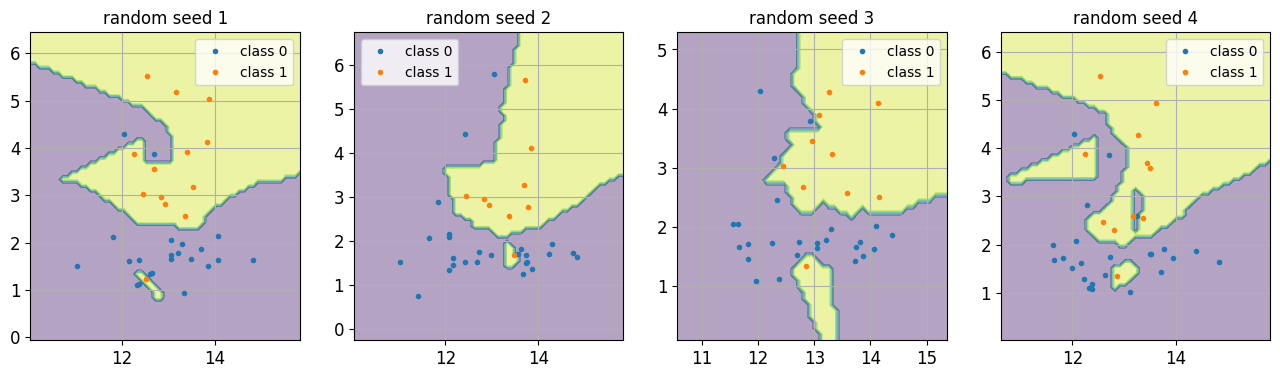

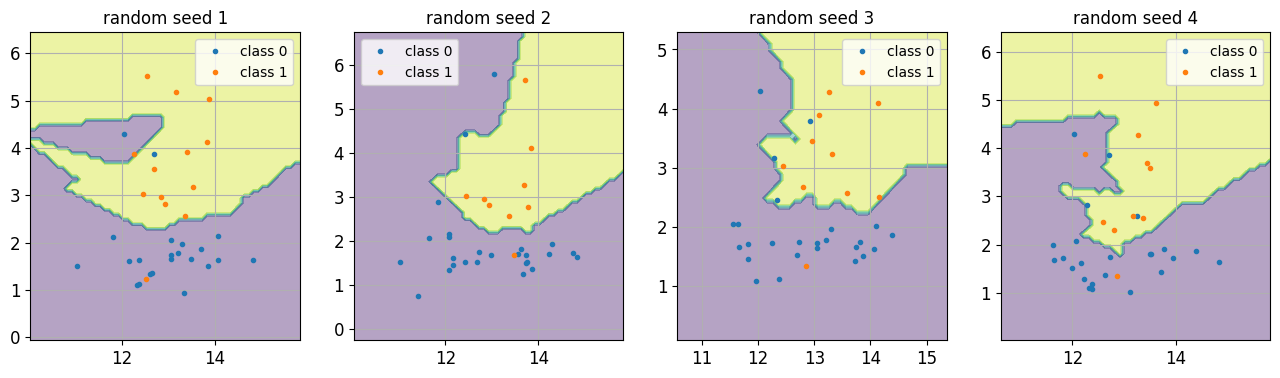

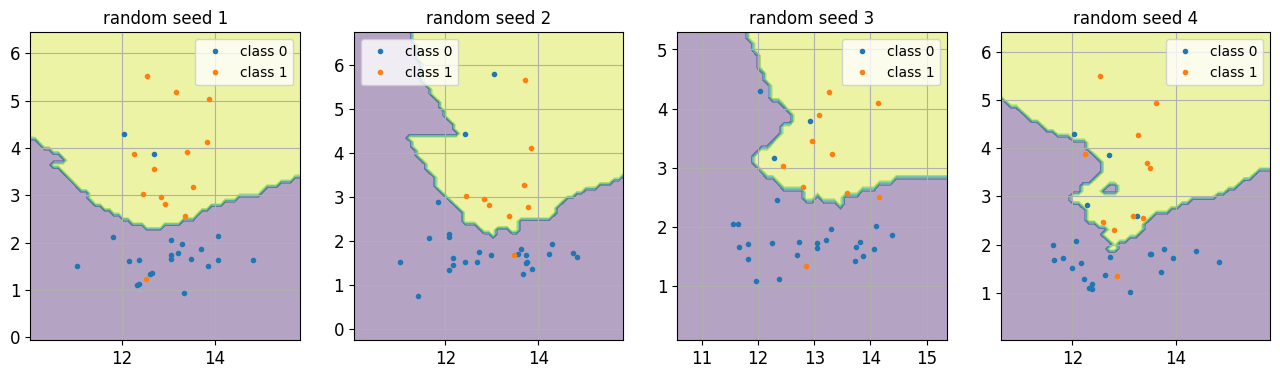

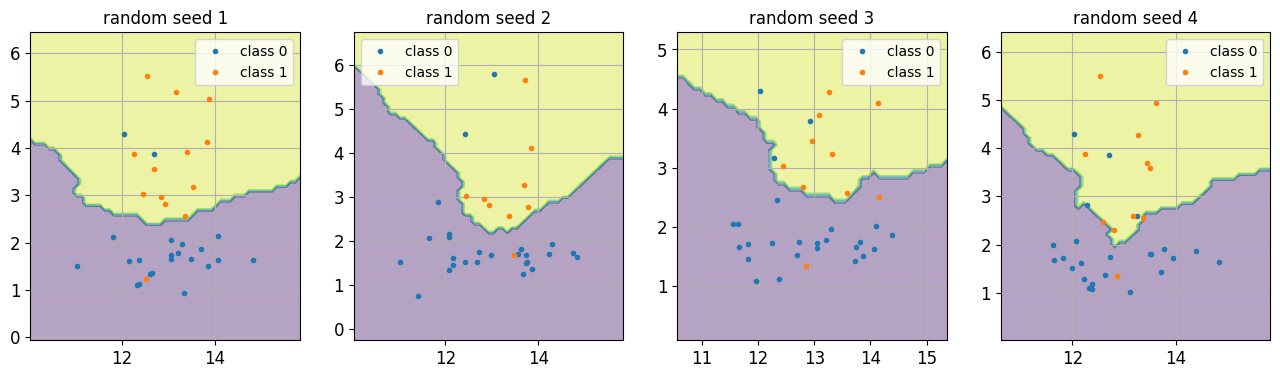

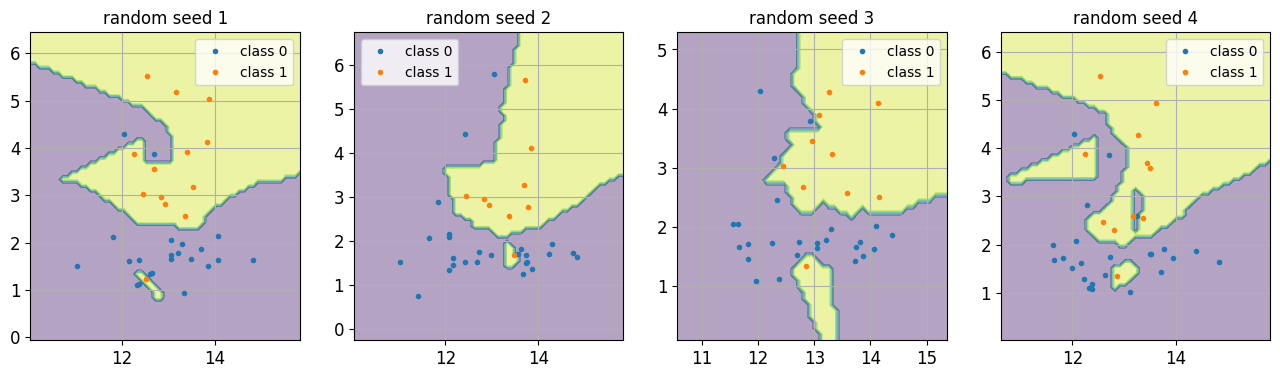

In [147]:
def show_knn_variance(k):
    plt.figure(figsize=(16,4))

    # train the k-NN classifier with different random splits of the training data
    for j, random_state in enumerate([1,10,42,100]):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=random_state)
        
        knn_clf = KNeighborsClassifier(k)
        knn_clf.fit(X_train, y_train)

        plt.subplot(1,4,j+1)
        plot_feature_space_function(X_train, y_train, knn_clf.predict)
        plt.title(f'random seed {j+1}')

ipywidgets.interact(show_knn_variance, k=ipywidgets.IntSlider(value=1,min=1, max=13,step=2))

Inspect using the interactive plot above how the $k$ affect the decision boundaries,
and how sensitive the classifier becomes for different subsets of the data.

Using the visualizations, answer the following questions:

- When does the KNN show high bias?

- When does the KNN show high variance?



In [ ]:
KNN_MOST_BIAS_WHEN_K_IS = '?'
#KNN_MOST_BIAS_WHEN_K_IS = 'small'
#KNN_MOST_BIAS_WHEN_K_IS = 'large'

KNN_MOST_VARIANCE_WHEN_K_IS = '?'
#KNN_MOST_VARIANCE_WHEN_K_IS = 'small'
#KNN_MOST_VARIANCE_WHEN_K_IS = 'large'

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
print('Q: When does the KNN show most bias, when k is small or large?')
print('A:', KNN_MOST_BIAS_WHEN_K_IS)
print()



In [ ]:
print('Q: When does the KNN show most variance, when k is small or large?')
print('A:', KNN_MOST_VARIANCE_WHEN_K_IS)
print()


#### 5.5.3 using your custom Gaussian-Mixture Model

Now let's try to do the same thing with the Gaussian-Mixture Bayesian classifier you built earlier.

interactive(children=(IntSlider(value=1, continuous_update=False, description='n_components', max=15, min=1), …

<function __main__.show_gmm_train_test(n_components=1)>

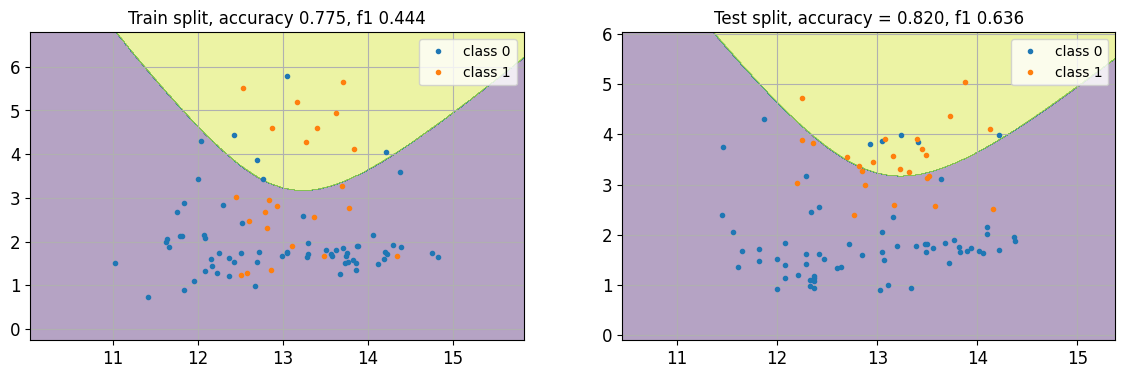

In [148]:
def show_gmm_train_test(n_components=1):
    print(n_components)
    gmm_clf = MyGmmClassifier(n_components=n_components)
    gmm_clf.fit(X_train, y_train)
    show_train_test_feature_space(gmm_clf, res=0.01)

ipywidgets.interact(show_gmm_train_test, n_components=ipywidgets.IntSlider(value=1,min=1, max=15, continuous_update=False))

**Q** When does the GMM generate the more complex decision boundary? At low or high number of components?

In [150]:
# answer by uncommenting only the correct options from this block below

# GMM_COMPLEX_BOUNDARY_WHEN_NUMCOMP_IS = '?'
#GMM_COMPLEX_BOUNDARY_WHEN_NUMCOMP_IS = 'small'
GMM_COMPLEX_BOUNDARY_WHEN_NUMCOMP_IS = 'large'



In [151]:
print('Your answer:', GMM_COMPLEX_BOUNDARY_WHEN_NUMCOMP_IS)


Your answer: large


interactive(children=(IntSlider(value=3, description='n_components', max=5, min=1), Output()), _dom_classes=('…

<function __main__.show_gmm_variance(n_components)>

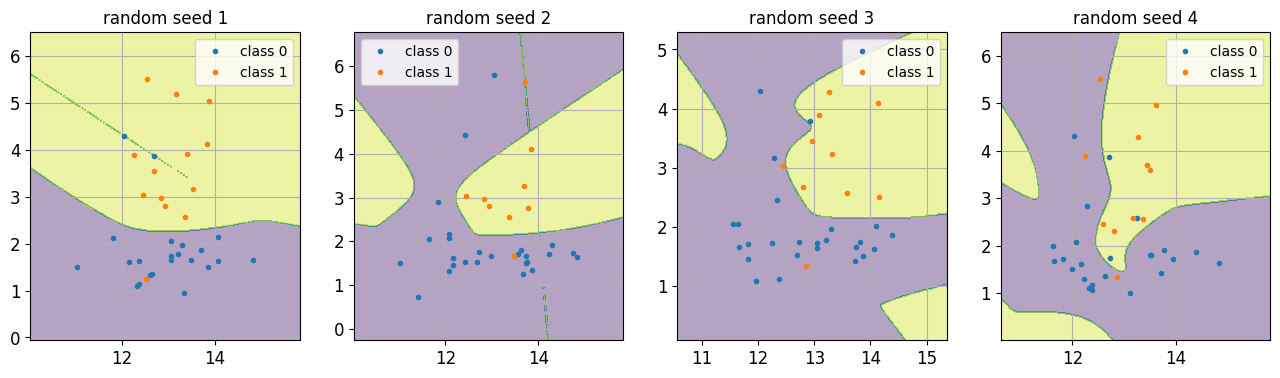

In [152]:
def show_gmm_variance(n_components):
    plt.figure(figsize=(16,4))

    # train the GMM classifier with different random splits of the training data
    for j, random_state in enumerate([1,10,42,100]):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=random_state)
        gmm_clf = MyGmmClassifier(n_components=n_components)
        gmm_clf.fit(X_train, y_train)

        plt.subplot(1,4,j+1)
        plot_feature_space_function(X_train, y_train, gmm_clf.predict, res=0.02)
        plt.title(f'random seed {j+1}')

ipywidgets.interact(show_gmm_variance, n_components=(1,5))

#### 5.5.4 Inspect using the interactive plot above how the number of components affect the decision boundaries,
and how sensitive the classifier becomes for different subsets of the data.

Using the visualizations, answer the following questions:
* When does the GMM show high bias?
* When does the GMM show high variance?

In [153]:
# GMM_MOST_BIAS_WHEN_NUMCOMP_IS = '?'
#GMM_MOST_BIAS_WHEN_NUMCOMP_IS = 'small'
GMM_MOST_BIAS_WHEN_NUMCOMP_IS = 'large'

# GMM_MOST_VARIANCE_WHEN_NUMCOMP_IS = '?'
#GMM_MOST_VARIANCE_WHEN_NUMCOMP_IS = 'small'
GMM_MOST_VARIANCE_WHEN_NUMCOMP_IS = 'large'


In [154]:
print('Q: When does the GMM show most bias, when # components is small or large?')
print('A:', GMM_MOST_BIAS_WHEN_NUMCOMP_IS)
print()


Q: When does the GMM show most bias, when # components is small or large?
A: large



In [155]:
print('Q: When does the GMM show most variance, when # components is small or large?')
print('A:', GMM_MOST_VARIANCE_WHEN_NUMCOMP_IS)
print()


Q: When does the GMM show most variance, when # components is small or large?
A: large



### 5.6 Regularization

In this part, we will explore the effect of using regularization, and how it affects the decision boundary.

The Support Vector Machine (SVM) is classifier with a regalurization parameter $C$.
The SVM can be used to estimate a linear classification boundary (`SVC(kernel=linear)`),
or a potentially more complex decision boundary with the so-called Radial Basis Function kernel (`SVC(kernel=rbf)`, the default kernel of sklearn's SVC). Note the sklearn calls this a Support Vector Classifier, SVC, instead of SVM.

Future lectures will discuss SVMs and kernel methods in more detail, so for now we will treat the SVM with RBF kernel as a black-box.


In [ ]:
svm_clf = sklearn.svm.SVC(kernel='rbf')

def show_svm_train_test(C):
    svm_clf.set_params(C=C)
    svm_clf.fit(X_train, y_train)
    show_train_test_feature_space(svm_clf, res=0.05)
    
    l2_weight = svm_clf.dual_coef_.dot(svm_clf.dual_coef_.T).flatten()[0]

    print('C =', C)
    print('norm of coefficients:', l2_weight)

ipywidgets.interact(show_svm_train_test, C=ipywidgets.FloatLogSlider(1.0, base=10, min=-1, max=8, continuous_update=False))

In [ ]:
def show_svm_variance(C):
    plt.figure(figsize=(16,4))
    for j, random_state in enumerate([1,10,42,100]):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=random_state)
        svm_clf.set_params(C=C)
        svm_clf.fit(X_train, y_train)

        plt.subplot(1,4,j+1)
        plot_feature_space_function(X_train, y_train, svm_clf.predict, res=0.02)
        plt.title(f'random seed {j+1}')
    print(C)

ipywidgets.interact(show_svm_variance, C=ipywidgets.FloatLogSlider(1.0, base=10, min=0, max=10, continuous_update=False))

* When is C most strongly regularizing the SVM, when it is large or small?
* When does the SVM show most bias, when C is small or large?
* When does the SVM show most variance, when C is small or large?

In [156]:
# answer by uncommenting only the correct options from this block below

SVM_STRONGEST_REGULARIZATION_WHEN_C_IS = 'small'
SVM_MOST_BIAS_WHEN_C_IS = 'small'
SVM_MOST_VARIANCE_WHEN_C_IS = 'large'


In [157]:
print('Q: When is C most strongly regularizing the SVM, when it is large or small?')
print('A:', SVM_STRONGEST_REGULARIZATION_WHEN_C_IS)
print()


Q: When is C most strongly regularizing the SVM, when it is large or small?
A: small



In [158]:
print('Q: When does the SVM show most bias, when C is small or large?')
print('A:', SVM_MOST_BIAS_WHEN_C_IS)
print()


Q: When does the SVM show most bias, when C is small or large?
A: small



In [159]:
print('Q: When does the SVM show most variance, when C is small or large?')
print('A:', SVM_MOST_VARIANCE_WHEN_C_IS)
print()


Q: When does the SVM show most variance, when C is small or large?
A: large



That wraps up this part of the exercises!